In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [17]:
assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
meta = load_meta()
meta.rename({'sample':'cell_line_id'}, axis=1, inplace=True)

## % reads that map to afr contigs by poputlation

In [5]:
def plot_thing(df, subset, thresh, how):
    """
    how = 'best' or 'any'
    """
    
    init_plot_settings(aspect='rectangle')
    temp = df.copy(deep=True)
    for key, value in subset.items():
        temp = temp.loc[temp[key]==value]
    # temp = df.loc[df.afr==True]
    # ax = sns.violinplot(temp, y='', hue='population', x='population', palette=c_dict, order=order) 
    # ax = sns.stripplot(temp, y='perc', x='', hue='population', palette=c_dict, order=order) 

    sns.violinplot(x='population', y='perc', data=temp, 
                   bw=0.2, order=order, inner=None, cut=0,
                   linewidth=1, scale='width', palette=c_dict)
    sns.stripplot(x='population', y='perc', data=temp,
                  jitter=True, order=order, palette=c_dict,
                  edgecolor='k', linewidth=0.5)


    ax = plt.gca()
    if how == 'any':
        title = f'% reads w/ MAPQ>={thresh} from each sample'
        ylabel = '% reads mapping to Afr. contigs'
    elif how == 'best':
        title = f'% of reads w/ MAPQ>={thresh} and BEST mapping from each sample'
        ylabel = '% reads mapping best to Afr. contigs'
    ax.set(title=title, ylabel=ylabel)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.show()


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


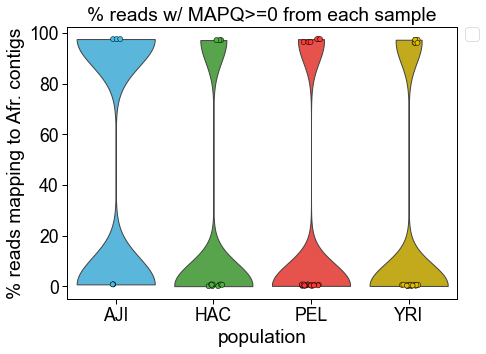

In [7]:
thresh = 0
f = expand(proc_cfg(config['lr']['map_personal']['mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')
c_dict, order = get_population_colors(cats=df.population.unique())

plot_thing(df, {'same_population_sample':True}, thresh, how='any')

## testing

In [81]:
thresh = 10
f = expand(proc_cfg(config['lr']['map_personal']['mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')

132
44


In [82]:
# try by double-counting reads based on if they map the same in multiple
# genome assemblies
temp = df.copy(deep=True)
gb_cols = ['cell_line_id', 'population', 'total_reads']
for i,a in enumerate(assemblies):
    gb_cols_2  = gb_cols + [a]
    keep_cols = gb_cols_2+['perc']
    temp2 = temp[keep_cols]
    temp2 = temp2.groupby(gb_cols_2).sum().reset_index()
    temp2 = temp2.loc[temp2[a] == True]
    temp2.rename({'perc': f'perc_{a}'}, axis=1, inplace=True)
    temp2.drop(a, axis=1, inplace=True)
    if i == 0:
        sum_df = temp2.copy(deep=True)
    else:
        sum_df = sum_df.merge(temp2, on=gb_cols)

In [83]:
sum_df.head()

,cell_line_id,population,total_reads,perc_same_population_sample,perc_afr_sample,perc_european_sample
0,GM18906,YRI,13422483,92.627020,92.299256,92.308465
1,GM19240,YRI,15996398,89.535507,90.025217,89.843870
2,GM24385,AJI,20882379,91.159207,91.044229,91.159207
3,HG00621,HAC,26329983,92.221769,92.279790,91.913428
4,HG01928,PEL,10672705,90.376395,90.699790,90.403258


In [84]:
sum_df.head()
sum_df.to_csv('map_personal_summary_at_all_10.tsv', sep='\t', index=False)

In [15]:
df.head()
assemblies

['sampe_population_sample', 'afr_sample', 'european_sample']

In [57]:
thresh = 10
f = expand(proc_cfg(config['lr']['map_personal']['max_mapq_tsv_summary'], od),
           thresh=thresh)[0]
df = pd.read_csv(f, sep='\t')
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))
df['cell_line_id'] = df.dataset.str.split('_', expand=True)[0]
df = df.merge(meta[['population', 'cell_line_id']],
              how='left', on='cell_line_id')

114
38


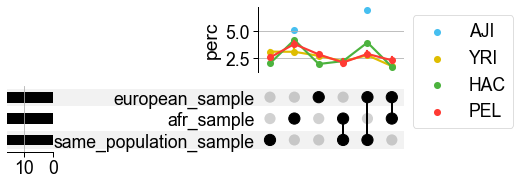

In [58]:
temp = df.copy(deep=True)
temp.set_index(assemblies, inplace=True)
temp.head()

# remove category where they all map best to all genoems
temp.reset_index(inplace=True)
temp = temp.loc[(temp[assemblies] == False).any(axis=1)]
temp.set_index(assemblies, inplace=True)

upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
# upset.add_catplot(value='perc', kind='violin', palette=c_dict)
c_dict, order = get_population_colors(cats=df.population.unique().tolist())
upset.add_catplot(value='perc', kind='point', hue='population', palette=c_dict)
ax = upset.plot()['extra0']
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [59]:
sns.__version__

'0.12.2'

In [75]:
# try by double-counting reads based on if they map the same in multiple
# genome assemblies
temp = df.copy(deep=True)
gb_cols = ['cell_line_id', 'population', 'total_reads']
for i,a in enumerate(assemblies):
    gb_cols_2  = gb_cols + [a]
    keep_cols = gb_cols_2+['perc']
    temp2 = temp[keep_cols]
    temp2 = temp2.groupby(gb_cols_2).sum().reset_index()
    temp2 = temp2.loc[temp2[a] == True]
    temp2.rename({'perc': f'perc_{a}'}, axis=1, inplace=True)
    temp2.drop(a, axis=1, inplace=True)
    if i == 0:
        sum_df = temp2.copy(deep=True)
    else:
        sum_df = sum_df.merge(temp2, on=gb_cols)

In [76]:
sum_df.head()

,cell_line_id,population,total_reads,perc_same_population_sample,perc_afr_sample,perc_european_sample
0,GM18906,YRI,12672718,92.921227,91.280387,91.873133
1,GM19240,YRI,14708966,91.935694,91.561664,91.318567
2,GM24385,AJI,19323787,94.874788,93.034140,94.874788
3,HG00621,HAC,24718661,92.150117,92.078612,91.570765
4,HG01928,PEL,9918009,90.833301,91.010655,90.773067


In [77]:
sum_df.head()
sum_df.to_csv('map_personal_summary_1.tsv', sep='\t', index=False)

In [66]:
df.loc[(df.cell_line_id=='GM18906')]

,same_population_sample,european_sample,afr_sample,n_reads,total_reads,perc,sample,dataset,cell_line_id,population
3,False,False,True,360347,12672718,2.843486,GM18906_1,GM18906_1,GM18906,YRI
4,False,True,False,351164,12672718,2.771024,GM18906_1,GM18906_1,GM18906,YRI
5,False,True,True,185562,12672718,1.464264,GM18906_1,GM18906_1,GM18906,YRI
6,True,False,False,406296,12672718,3.206068,GM18906_1,GM18906_1,GM18906,YRI
7,True,False,True,263252,12672718,2.077313,GM18906_1,GM18906_1,GM18906,YRI
8,True,True,False,347552,12672718,2.742521,GM18906_1,GM18906_1,GM18906,YRI
9,True,True,True,10758545,12672718,84.895324,GM18906_1,GM18906_1,GM18906,YRI


,cell_line_id,population,total_reads,same_population_sample,perc_x,afr_sample,perc_y,european_sample,perc
0,GM18906,YRI,12672718,False,7.078773,False,8.719613,False,8.126867
1,GM18906,YRI,12672718,False,7.078773,False,8.719613,True,91.873133
2,GM18906,YRI,12672718,False,7.078773,True,91.280387,False,8.126867
3,GM18906,YRI,12672718,False,7.078773,True,91.280387,True,91.873133
4,GM18906,YRI,12672718,True,92.921227,False,8.719613,False,8.126867
